# Testing
## Geburten nach Tag, Stadtquartier, Geschlecht, Altersgruppe und Herkunft, seit 1998
Datum: 20.01.2022

### Importiere die notwendigen Packages

In [126]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [127]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [128]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [129]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 1 datenstand:  -1 time.struct_time(tm_year=2022, tm_mon=1, tm_mday=21, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=21, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [130]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_tag_geburten_quartier_geschl_ag_herkunft_od403

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bev_tag_geburten_quartier_geschl_ag_herkunft_od403

In [131]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ";
print(status)

integ


In [132]:
# Filepath
if status == "prod":
    #fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bev_monat_bestand_quartier_geschl_ag_herkunft_od3250/BEV325OD3250.csv"
    fp = r"https://data.stadt-zuerich.ch/dataset/bev_tag_geburten_quartier_geschl_ag_herkunft_od4031/download/BEV403OD4031.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bev_tag_geburten_quartier_geschl_ag_herkunft_od4031\BEV403OD4031.csv" #tag todesfälle
  #fp = r"https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_tag_todesfaelle_quartier_geschl_ag_herkunft_od4211/download/BEV421OD4211.csv"


print(fp)

\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bev_tag_geburten_quartier_geschl_ag_herkunft_od4031\BEV403OD4031.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [133]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
    parse_dates=['GueltigAbDat'],
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    date_parser=lambda s: epoch + datetime.timedelta(days=int(s)),
    low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [134]:
data2betested.sort_values(by=['GueltigAbDatJahr','GueltigAbDatMM'], ascending=False).head(3)

,GueltigAbDatJahr,GueltigAbDatMM,GueltigAbDatDD,GueltigAbDat,SexCd,SexLang,HerkunftCd,HerkunftLang,KreisCd,KreisLang,QuarCd,QuarLang,DatenstandCd,DatenstandLang,AnzGebuWir
97234,2021,11,1,2021-11-01,1,männlich,1,Schweizer/in,5,Kreis 5,52,Escher Wyss,P,Provisorisch,1
97235,2021,11,1,2021-11-01,1,männlich,1,Schweizer/in,8,Kreis 8,81,Seefeld,P,Provisorisch,1
97236,2021,11,1,2021-11-01,1,männlich,1,Schweizer/in,9,Kreis 9,91,Albisrieden,P,Provisorisch,1


In [135]:
data2betested.dtypes

GueltigAbDatJahr             int64
GueltigAbDatMM               int64
GueltigAbDatDD               int64
GueltigAbDat        datetime64[ns]
SexCd                        int64
SexLang                     object
HerkunftCd                   int64
HerkunftLang                object
KreisCd                      int64
KreisLang                   object
QuarCd                       int64
QuarLang                    object
DatenstandCd                object
DatenstandLang              object
AnzGebuWir                   int64
dtype: object

In [136]:
data2betested.shape

(97579, 15)

Beschreibe einzelne Attribute

In [137]:
data2betested.describe()

,GueltigAbDatJahr,GueltigAbDatMM,GueltigAbDatDD,SexCd,HerkunftCd,KreisCd,QuarCd,AnzGebuWir
count,97579,97579,97579,97579,97579,97579,97579,97579
mean,2010,7,16,1,1,7,75,1
std,7,3,9,0,0,3,34,0
min,1998,1,1,1,1,1,11,1
25%,2005,4,8,1,1,4,42,1
50%,2011,7,16,1,1,8,81,1
75%,2016,9,23,2,2,10,102,1
max,2021,12,31,2,2,12,123,5


Wie viele Nullwerte gibt es im Datensatz?

In [138]:
data2betested.isnull().sum()

GueltigAbDatJahr    0
GueltigAbDatMM      0
GueltigAbDatDD      0
GueltigAbDat        0
SexCd               0
SexLang             0
HerkunftCd          0
HerkunftLang        0
KreisCd             0
KreisLang           0
QuarCd              0
QuarLang            0
DatenstandCd        0
DatenstandLang      0
AnzGebuWir          0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [139]:
data2betested = data2betested.set_index("GueltigAbDat")
#data2betested = data2betested.drop(columns=["StichtagDatMM"])

In [140]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97579 entries, 1998-01-01 to 2021-11-30
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   GueltigAbDatJahr  97579 non-null  int64 
 1   GueltigAbDatMM    97579 non-null  int64 
 2   GueltigAbDatDD    97579 non-null  int64 
 3   SexCd             97579 non-null  int64 
 4   SexLang           97579 non-null  object
 5   HerkunftCd        97579 non-null  int64 
 6   HerkunftLang      97579 non-null  object
 7   KreisCd           97579 non-null  int64 
 8   KreisLang         97579 non-null  object
 9   QuarCd            97579 non-null  int64 
 10  QuarLang          97579 non-null  object
 11  DatenstandCd      97579 non-null  object
 12  DatenstandLang    97579 non-null  object
 13  AnzGebuWir        97579 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 11.2+ MB


Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
            23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='GueltigAbDat')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [141]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [142]:
data2betested.loc["2021-11"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,GueltigAbDatJahr,GueltigAbDatMM,GueltigAbDatDD,SexCd,SexLang,HerkunftCd,HerkunftLang,KreisCd,KreisLang,QuarCd,QuarLang,DatenstandCd,DatenstandLang,AnzGebuWir
GueltigAbDat,,,,,,,,,,,,,,
2021-11-01,2021,11,1,1,männlich,1,Schweizer/in,5,Kreis 5,52,Escher Wyss,P,Provisorisch,1
2021-11-01,2021,11,1,1,männlich,1,Schweizer/in,8,Kreis 8,81,Seefeld,P,Provisorisch,1


### Aggriere Werte nach Zeitausschnitten

Mit den Funktionen zur Zeit kann einfach zwischen Stunden, Tagen, Monaten, etc. gewechselt und aggregiert werden.
Da die Daten bereits aggregiert nach Monaten sind, macht das hier keinen Sinn.
Untenstehendes also nur als BSP


In [145]:
# first we create the sums per week
weekly_sums = data2betested.resample("W").sum()
# then we generate the weekly means for each quarter
data2betested_sel = data2betested[["SexCd","KreisLang","AnzGebuWir"]]
quarterly_sums = data2betested_sel.resample("Q").sum()
# for readability we'll revert the values back to integers
quarterly_sums.astype(int).head(1)

,SexCd,AnzGebuWir
GueltigAbDat,,
1998-03-31,1234,897


### Visualisierungen nach Zeitausschnitten

In [ ]:
data2betested.info()
#data2betested

#### Entwicklung Todesfälle nach Stadtkreis

In [146]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2020-11":"2021-11"] \
    .groupby(['GueltigAbDat','GueltigAbDatJahr', 'GueltigAbDatMM','SexLang']) \
    .agg(sum_WBev=('AnzGebuWir', 'sum')) \
    .sort_values('sum_WBev', ascending=False) 

myAgg.reset_index().head(2)

,GueltigAbDat,GueltigAbDatJahr,GueltigAbDatMM,SexLang,sum_WBev
0,2021-07-12,2021,7,männlich,16
1,2021-10-14,2021,10,männlich,16


In [147]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['KreisLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>1'), title="Title").encode(
    x=alt.X('GueltigAbDat', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('SexLang', legend=alt.Legend(title="Stadtkreise", orient="right"))  
    ,tooltip=['GueltigAbDat', 'SexLang', 'sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=900 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung nach Geschlecht

In [150]:
#myAgg = data2betested.loc["2008-11":"2021-11"] \
myAgg = data2betested.loc["2020-11":"2021-11"] \
    .groupby(['GueltigAbDat','GueltigAbDatJahr', 'GueltigAbDatMM', 'SexLang']) \
    .agg(sum_WBev=('AnzGebuWir', 'sum')) \
    .sort_values('sum_WBev', ascending=False) 

myAgg.reset_index().head(2)

,GueltigAbDat,GueltigAbDatJahr,GueltigAbDatMM,SexLang,sum_WBev
0,2021-07-12,2021,7,männlich,16
1,2021-10-14,2021,10,männlich,16


In [151]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['SexLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>1'), title="Title").encode(
    x=alt.X('GueltigAbDat', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('SexLang', legend=alt.Legend(title="Geschlecht", orient="right"))  
    ,tooltip=['GueltigAbDat', 'SexLang', 'sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=900 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung nach Heimat

In [153]:
#myAgg = data2betested.loc["2008-11":"2021-11"] \
myAgg = data2betested.loc["2020-11":"2021-11"] \
    .groupby(['GueltigAbDat','GueltigAbDatJahr', 'GueltigAbDatMM', 'HerkunftLang']) \
    .agg(sum_WBev=('AnzGebuWir', 'sum')) \
    .sort_values('sum_WBev', ascending=False) 

myAgg.reset_index().head(2)

,GueltigAbDat,GueltigAbDatJahr,GueltigAbDatMM,HerkunftLang,sum_WBev
0,2021-01-08,2021,1,Schweizer/in,20
1,2021-07-12,2021,7,Schweizer/in,19


In [154]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['HerkunftLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>1'), title="Title").encode(
    x=alt.X('GueltigAbDat', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('HerkunftLang', legend=alt.Legend(title="Herkunft"))  
    ,tooltip=['GueltigAbDat', 'HerkunftLang', 'sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=900 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points    


alt.LayerChart(...)

In [155]:
data2betested.dtypes

GueltigAbDatJahr     int64
GueltigAbDatMM       int64
GueltigAbDatDD       int64
SexCd                int64
SexLang             object
HerkunftCd           int64
HerkunftLang        object
KreisCd              int64
KreisLang           object
QuarCd               int64
QuarLang            object
DatenstandCd        object
DatenstandLang      object
AnzGebuWir           int64
dtype: object

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Aktueller Bestand der WBev nach Stadtkreis, Quartier, Geschlecht und Herkunft

In [157]:
myTreemapAgg = data2betested.loc["2021-11"]  \
    .groupby(['GueltigAbDat','GueltigAbDatJahr', 'GueltigAbDatMM', 'KreisLang','QuarLang','HerkunftLang', 'SexLang' ]) \
    .agg(sum_WBev=('AnzGebuWir', 'sum')) \
    .sort_values('sum_WBev', ascending=False) 

myTreemapAgg.reset_index().head(2)

,GueltigAbDat,GueltigAbDatJahr,GueltigAbDatMM,KreisLang,QuarLang,HerkunftLang,SexLang,sum_WBev
0,2021-11-12,2021,11,Kreis 11,Affoltern,Schweizer/in,männlich,4
1,2021-11-16,2021,11,Kreis 12,Hirzenbach,Schweizer/in,weiblich,3


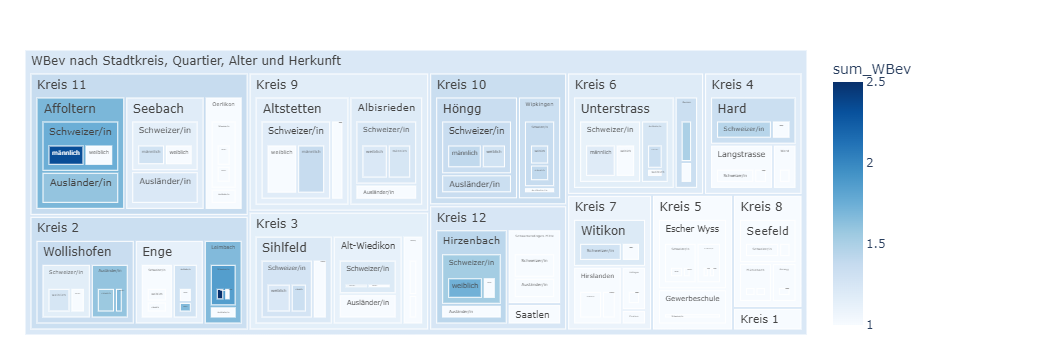

In [159]:
fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant("WBev nach Stadtkreis, Quartier, Alter und Herkunft"), 'KreisLang','QuarLang','HerkunftLang', 'SexLang']
                 , values='sum_WBev'
                 , color='sum_WBev'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 #,height=400
                 #,width=1500                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Aktueller Bestand der WBev nach Stadtkreis, Alter und Herkunft

In [162]:
myTreemapAgg = data2betested.loc["2019-11":"2021-11"]  \
    .groupby(['GueltigAbDat','GueltigAbDatJahr', 'GueltigAbDatMM', 'KreisLang','HerkunftLang', 'SexLang']) \
    .agg(sum_WBev=('AnzGebuWir', 'sum')) \
    .sort_values('sum_WBev', ascending=False) 

myTreemapAgg.reset_index().head(2)

,GueltigAbDat,GueltigAbDatJahr,GueltigAbDatMM,KreisLang,HerkunftLang,SexLang,sum_WBev
0,2020-10-20,2020,10,Kreis 10,Schweizer/in,männlich,6
1,2020-04-08,2020,4,Kreis 6,Schweizer/in,männlich,6


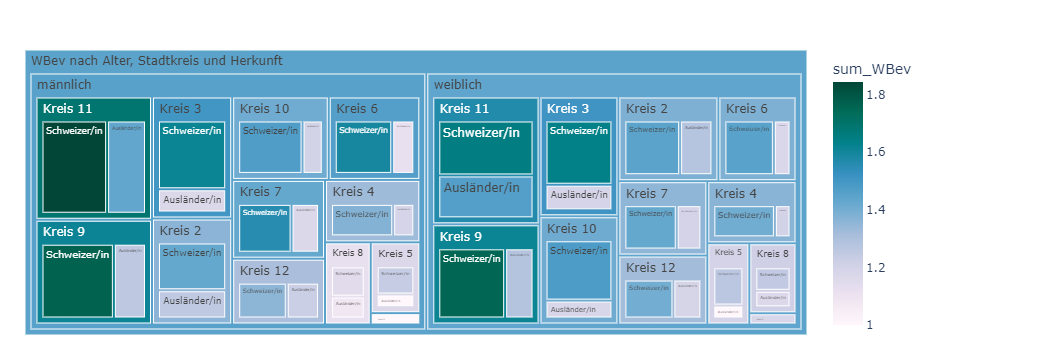

In [163]:
fig = px.treemap(myTreemapAgg.reset_index()
                 , path=[px.Constant("WBev nach Alter, Stadtkreis und Herkunft"), 'SexLang','KreisLang','HerkunftLang']
                 , values='sum_WBev'
                 , color='sum_WBev'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='PuBuGn'
                #, color_continuous_midpoint=np.average(myTreemapAgg['sum_WBev'], weights=myTreemapAgg['sum_WBev']) 
                 #,height=400
                 #,width=1500
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))#, title="WBev nach Alter, Stadtkreis und Herkunft")
fig.show()

-------------------------------------- stop hier

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

In [153]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Wenn die Daten lokal agelegt sind, dann kannst Du folgendes machen:
##input_stadtquartiere = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statistische_quartiere_map.json"
##df_stadtquartiere = gpd.read_file(input_stadtquartiere)
##df_stadtquartiere.head(2)
#df_stadtkreise.dtypes

geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [154]:
akt_wbev_quart = data2betested.loc["2021-11"].groupby(
    ['StichtagDatJahr','StichtagDatMM','QuarCd','QuarLang']
).agg(
    {'AnzBestWir':'sum'}
)
akt_wbev_quart.head()


AnzBestWir
StichtagDatJahr StichtagDatMM QuarCd QuarLang               
2021            11            11     Rathaus            3283
                              12     Hochschulen         718
                              13     Lindenhof          1033
                              14     City                835
                              21     Wollishofen       20002

In [158]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(akt_wbev_quart, on='QuarCd')

stadtquartiere_shapes_joined.head(2)


,geometry,QuarCd,qname,knr,AnzBestWir
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,7342
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,5564


<AxesSubplot:>

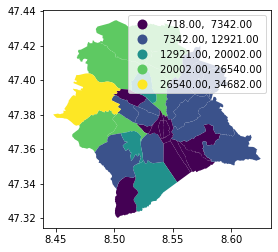

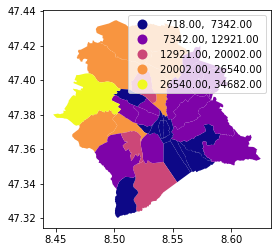

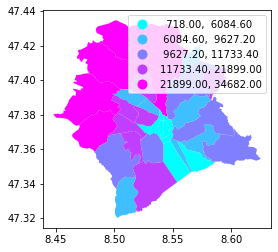

In [159]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='plasma', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=157&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**